# Case Study Part 2: Insights
This notebook is running on a Google Colab L4 CPU environment. In this section, the metrics inferred from the data in part 1 of the case study are clustered, analyzed and visualized.

In [1]:
%%capture
#!pip install numpy --upgrade #(uncomment install lines if running first time in google colab)
#!pip install scipy --upgrade
#!pip install gensim #(refresh kernel after installing to load new library and recomment installs)

In [45]:
%%capture
import pandas as pd
import gensim #gensim is used for a latent text embedding model for clustering text by meaning
from gensim.models import LdaMulticore
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
!pip install wordcloud
from wordcloud import WordCloud

In [3]:
from gensim.models.phrases import Phrases
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.cluster import KMeans
#from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import numpy as np

In [4]:
%%capture
!pip install datasets
from datasets import load_dataset
from google.colab import userdata

In [5]:
data = load_dataset("skeskinen/TinyStories-GPT4")

In [6]:
data_df = data['train'].to_pandas()

In [7]:
word_occurrences = pd.read_csv('word_occurrences.csv')

In [8]:
feature_occurrences = pd.read_csv('feature_occurrences.csv')

# Statistical Analysis and Visualization
In this section the statistical metrics calculated from the training data is analyzed and visualized for making insights with regards to the stated objectives. Furthermore, given the complexity in understanding the level of literacy from the data - as no 'literacy level' column is within the data - a language model is used to classify the responses.

## Mental Health
As for mental-health, goals may be defined in objective terms by inferring the emotions, subjects, topics, genres, or any commonly used keywords related to mental-health within the data. For this purpose, we can use the list of words and narrative features provided within the prompts provided to the AI in the training data for each row in the dataset. By counting the occurrences of the 'words' and 'features' columns used within the prompt, we can make some insights of the mental-health objectives.

### Objective: Highlight narrative features that relate to mental health.

#### Narrative Features
Some of the 'feature narrative' words provided to the model within the prompt template's in the training dataset give insight into whether the story may contain any emotional subjects or topics related to mental health. A bar plot is shown that highlights the amount of each feature narrative.

In [9]:
# converting the counts of feature occurrences to probability values
feature_occurence_probabilities = feature_occurrences['feature_occurrences'] / feature_occurrences['feature_occurrences'].sum()

In [10]:
feature_occurence_probabilities.index = feature_occurrences['feature']

##### **Mental Health Insight**
We can see from the bar chart that the majority of narratives have dialogue (i.e speech between characters in a story). Similarly, 'twists' and 'moralvalue' are 2nd and 3rd respectively, highlighting how the majority of prompts seek to generate interesting stories where characters interact and exemplify moral values. On the other end of the spectrum, the story prompts in the training data generate stories with narratives like foreshadowing, conflict, and bad endings. As our target demographic is youth, it might be a good idea to do further investigation on story prompts that contain the 'conflict' and 'badending' narrative tags - these combined tags are contained in roughly **20%** of the prompts.


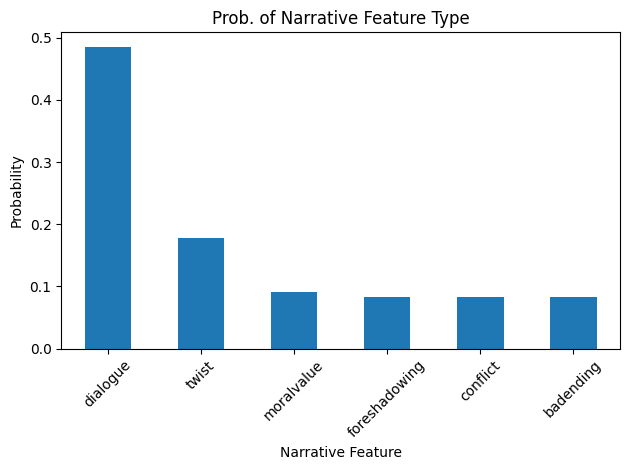

In [111]:
ax = feature_occurence_probabilities.sort_values(ascending=False).plot(
    kind='bar',
    title='Prob. of Narrative Feature Type'
)

# Correctly set labels using set methods
plt.ylabel('Probability')
plt.xlabel('Narrative Feature')
plt.xticks(rotation=45)

# Optional: Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

In [66]:
feature_occurrences.describe()

,feature_occurrences
count,6.000000e+00
mean,5.059540e+05
std,4.859297e+05
min,2.503000e+05
25%,2.507192e+05
50%,2.624705e+05
75%,4.730752e+05
max,1.470404e+06


In [72]:
feature_occurence_probabilities

,feature_occurrences
feature,
dialogue,0.484367
moralvalue,0.090309
twist,0.177679
foreshadowing,0.082613
badending,0.082452
conflict,0.082582


In [76]:
# Sum of 'badending' & 'conflict'
badending_conflict_narrative_probability = feature_occurence_probabilities.loc[
    feature_occurence_probabilities.index.isin(['badending', 'conflict'])
].sum()

# Sum of dialogue, twist, and foreshadowing
dialogue_twist_foreshadowing_narrative_probability = feature_occurence_probabilities.loc[
    feature_occurence_probabilities.index.isin(['dialogue', 'twist', 'foreshadowing'])
].sum()

# Summing mental health related narratives
mental_health_narrative_probability = badending_conflict_narrative_probability + feature_occurence_probabilities.loc['moralvalue']

In [102]:
def plot_topic_counts(df, title="Topics", xlabel="Topic", ylabel="Probability", pre_normalized=False):
    if not pre_normalized:
      # Getting topic counts and labels
      topic_counts = df['topic'].value_counts(normalize=True)
    else:
      topic_counts = df['probability'].sort_values(ascending=False)
    labels = topic_counts.index.tolist()
    counts = topic_counts.values.tolist()

    # Plotting the bars with distinct colors
    # Generating distinct colors using a colormap
    num_bars = len(labels)
    cmap = plt.get_cmap('viridis', num_bars)  # Choose a colormap

    bars = plt.bar(labels, counts, color=[cmap(i) for i in range(num_bars)])

    # Setting chart elements
    plt.title(title)
    # Hiding x-ticks and labels
    plt.xticks([])
    plt.ylabel(ylabel)
    #plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()  # Prevents labels from overlapping

    # Generating legend handles with x-axis labels as legend entries
    legend_handles = [mpatches.Patch(color=cmap(i), label=label) for i, label in enumerate(labels)]

    # Smaller legend with adjusted position
    plt.legend(handles=legend_handles, title=xlabel, loc='upper right', fontsize='small', bbox_to_anchor=(1.02, 1))

    plt.show()

In [114]:
print(f"Probability of Mental Health Narrative: {mental_health_narrative_probability}")
print(f"Probability of Dialogue, Twist, and Foreshadowing Narrative: {dialogue_twist_foreshadowing_narrative_probability}")
print(f"Probability of Badending and Conflict Narrative: {badending_conflict_narrative_probability}")
print(f"Probability of MoralValue Narrative: {mental_health_narrative_probability - badending_conflict_narrative_probability}")
# making a df of these probabilities
narrative_probabilities_df = pd.DataFrame({
    'topic': ['Mental Health', 'Dialogue, Twist, and Foreshadowing', 'Badending and Conflict', 'MoralValue'],
    'probability': [mental_health_narrative_probability, dialogue_twist_foreshadowing_narrative_probability, badending_conflict_narrative_probability, mental_health_narrative_probability - badending_conflict_narrative_probability]
})
# make into series by making topic the index
narrative_probabilities_df = narrative_probabilities_df.set_index('topic')

Probability of Mental Health Narrative: 0.2553420534936641
Probability of Dialogue, Twist, and Foreshadowing Narrative: 0.7446579465063359
Probability of Badending and Conflict Narrative: 0.16503344836355346
Probability of MoralValue Narrative: 0.09030860513011066


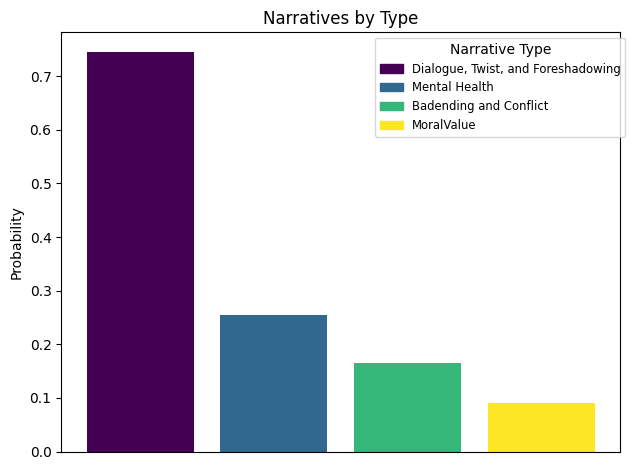

In [104]:
plot_topic_counts(narrative_probabilities_df, title='Narratives by Type', xlabel='Narrative Type', ylabel='Probability', pre_normalized=True)

##### **Statistical Insight**
The description of the feature occurrences show that the average count of prompts with each narrative type is typically ~500,000 for each. However, the 50% quantile is ~260,000 showing that the majority of narrative types are roughly half as large as the mean. This implies that there are outlier narratives skewing the distribution up. The 'dialogue' and 'twist' narrative types are outliers, and are contained within ~50% and ~20% of the story prompts respectively, and combined contribute to ~70% of the story prompts.

The plot of the narrative features by type show that the non-mental-health related narratives dominate the narrative features in the sampled prompts with ~75% of the narratives. Mental health narratives amount to ~25% of the rest of the narratives. **Within the mental health narrative category, the combined 'badending and conflict' narratives outweigh the 'moralvalue' narratives by almost double.**

**Note**: Most of the prompts range in number of narrative tags, and may contain either none or all of the tags described above. As such, it is worth investigating how these tags correlate. For example, a combined 'badending' and 'conflict' narrative lacking a 'moralvalue' tag might lead to risky or insensitive storytelling.

**These insight are made with only a small sample of the overall training data.**

#### Key Words
The key words column 'words' in the data are specific key vocabulary words provided to the AI in the story generation prompt. These words differ from the narrative feature words as the key words must be included in the generated story - whereas the narrative features are abstract storytelling features.

In [13]:
# converting the counts of feature occurrences to probability values
word_occurrence_probabilities = word_occurrences['word_occurrences'] / word_occurrences['word_occurrences'].sum()

In [14]:
word_occurrence_probabilities.index = word_occurrences['word']

In [15]:
word_occurrence_probabilities.describe()

,word_occurrences
count,1603.000000
mean,0.000624
std,0.000422
min,0.000294
25%,0.000311
50%,0.000319
75%,0.000854
max,0.002497


As the collection of vocabulary words within the dataset is large (~1604), the data must be clustered along the words' sentiment/meaning using a text embedding model. This way, we can reduce the dimensionality of the data while somewhat preserving the intended meaning of the collection. Given the individual probabilities for each word are very small (on the scale of 1/1000 likeliness), clustering to reduce the dimensionality will help understand the salient groups of words that are commonly paired within each vocab key collection.

In [16]:
# step 1: prepare the n-grams
data_df['words'].head() # every collection of words is already of length 3 (trigram format)

,words
0,"[receive, opera, red]"
1,"[use, sheet, blue]"
2,"[relax, bus, uncomfortable]"
3,"[sail, cricket, wide]"
4,"[pray, pigeon, creative]"


Since the dataset is large, clustering can not be executed in one execution - even with Google Colabs biggest ram environment. Therefore, the data will be clustered in iterations via bootstrapping. In this way, the data will be clustered in batches and then aggregated.

In [17]:
# note: vectorizer must be initialized outside the loop
# in order to maintain the training data across batches

# Step 2: LDA Clustering the batched TF-IDF matrix with
def bootstrap_clustering(data, num_clusters, num_iterations, batch_size):
    """
    Performs bootstrapped clustering on the data, incorporating TF-IDF creation within the loop.

    Args:
        data: The data to cluster (the 'words' column of your DataFrame).
        num_topics: The number of clusters in the LDA clustering.
        num_iterations: The number of iterations.
        batch_size: The batch size.

    Returns:
        A list of cluster assignments for each data point.
    """

    all_topic_assignments = []
    batches = []
    topic_assignment_batches = []
    # Initialize lists to store cluster statistical metrics
    coherence_scores = []
    perplexity_scores = []

    data_size = len(data)

    for _ in range(num_iterations):
        # Randomly sample a batch of data
        batch_indices = np.random.choice(data_size, size=batch_size, replace=True)
        batch_data = data.iloc[batch_indices]['words']  # Select the 'words' column
        batches.append(batch_data)

        # Prepare data for LDA
        dictionary = Dictionary([word for word in batch_data.values])
        corpus = [dictionary.doc2bow(text) for text in batch_data.values]

        # Perform LDA on the batch
        lda_model = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=15, workers=2)
        batch_topic_assignments = [max(lda_model[doc], key=lambda item: item[1])[0] for doc in corpus]

        topic_assignment_batches.append(batch_topic_assignments)
        # Append the cluster assignments to the list
        all_topic_assignments.extend(batch_topic_assignments)
        # Calculate and store metrics for this iteration
        coherence_model = CoherenceModel(model=lda_model, texts=batch_data.values, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)

        perplexity = lda_model.log_perplexity(corpus)
        perplexity_scores.append(perplexity)

    return all_topic_assignments, batches, topic_assignment_batches, coherence_scores, perplexity_scores

In [18]:
num_topics = 12 # 12 is chosen to be able to visualize wordcloud in grid format
num_iterations = 10  # Adjust as needed
batch_size = 1500  # This number is close to the maximum compute

# Perform bootstrapped clustering
topic_assignments, batches, topic_assignment_batches, coherence_scores, perplexity_scores = bootstrap_clustering(
    data_df, num_topics, num_iterations, batch_size
)

# Assign the cluster assignments to the original DataFrame
# word_trigram_df['cluster'] = cluster_assignments

In [19]:
cluster_assignments_df = pd.DataFrame(topic_assignments, columns=['topic'])
# adding in a cluster iteration index
cluster_assignments_df['iteration'] = cluster_assignments_df.index // batch_size

In [20]:
cluster_counts_by_iteration = cluster_assignments_df.groupby('iteration')['topic'].value_counts()

<Axes: xlabel='iteration'>

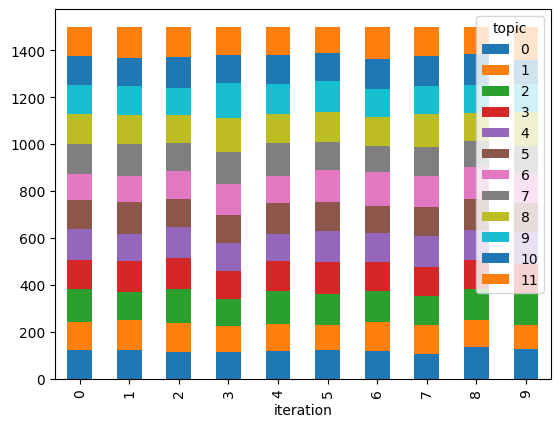

In [21]:
# let's visualize the distribution of cluster counts by iteration by showing a bar chart with a legend using the iteration
cluster_counts_by_iteration.unstack().plot(kind='bar', stacked=True, legend=True)

Since the topics discovered via LDA clustering are abstract, classification of these topics into a understandable theme may be done using a large language model with a prompt to classify into the existing objectives of 'mental health' or 'creativity'.

In [22]:
mental_health_topics = [
    "Dealing with Fear and Anxiety",
    "Coping with Sadness and Loss",
    "Managing Anger and Frustration",
    "Practicing Gratitude and Mindfulness",
    "Developing Healthy Relationships with Family",
    "Developing Healthy Relationships with Friends"
]

creativity_topics = [
    "Thinking Outside the Box",
    "Embracing Imagination and Curiosity",
    "Using Art and Expression",
    "Music",
    "Painting",
    "Sculpting"]

In [23]:
# let's create a function to call openAI's chatgpt-4o with a prompt to classify topics
import openai
import os

client = openai.OpenAI(api_key=userdata.get('openai'))
model = 'gpt-4o-mini'
def classify_topics(mental_health_topics, creativity_topics, topic_df_words_counts):
    """ this takes a preset list of mental health and creativity topics,
        and classifies the topic_ids by using the data in the topic_df_words
        note: there are 12 topic_ids, and 6 mental health topics, and 6 creativity topics
        thus only one topic_id can be classified into one of the 2 categories
        """
    prompt_template = (
        f"The following is a list of mental health topics: {mental_health_topics}",
        f"The following is a list of creative topics: {creativity_topics}",
        f"Use this list of words and their counts to classify the most likely topic: {topic_df_words_counts}",
        "Note: Each topic in either list can be assigned only once. Only respond with the topic chosen and nothing else. The topic headers (creative or mental health) are not allowed.",
        "Topic: "
    )
    prompt = "\n".join(prompt_template)
    response = client.chat.completions.create(
        messages=[
            {"role": "system", "content": "You are comfortable classifying the language used in stories by simply inferring based on words and classifying a collection into either creative or mental health topics."},
            {"role": "user", "content": prompt}
        ],
        model = model,
        temperature = 0.0
    )
    return response.choices[0].message.content


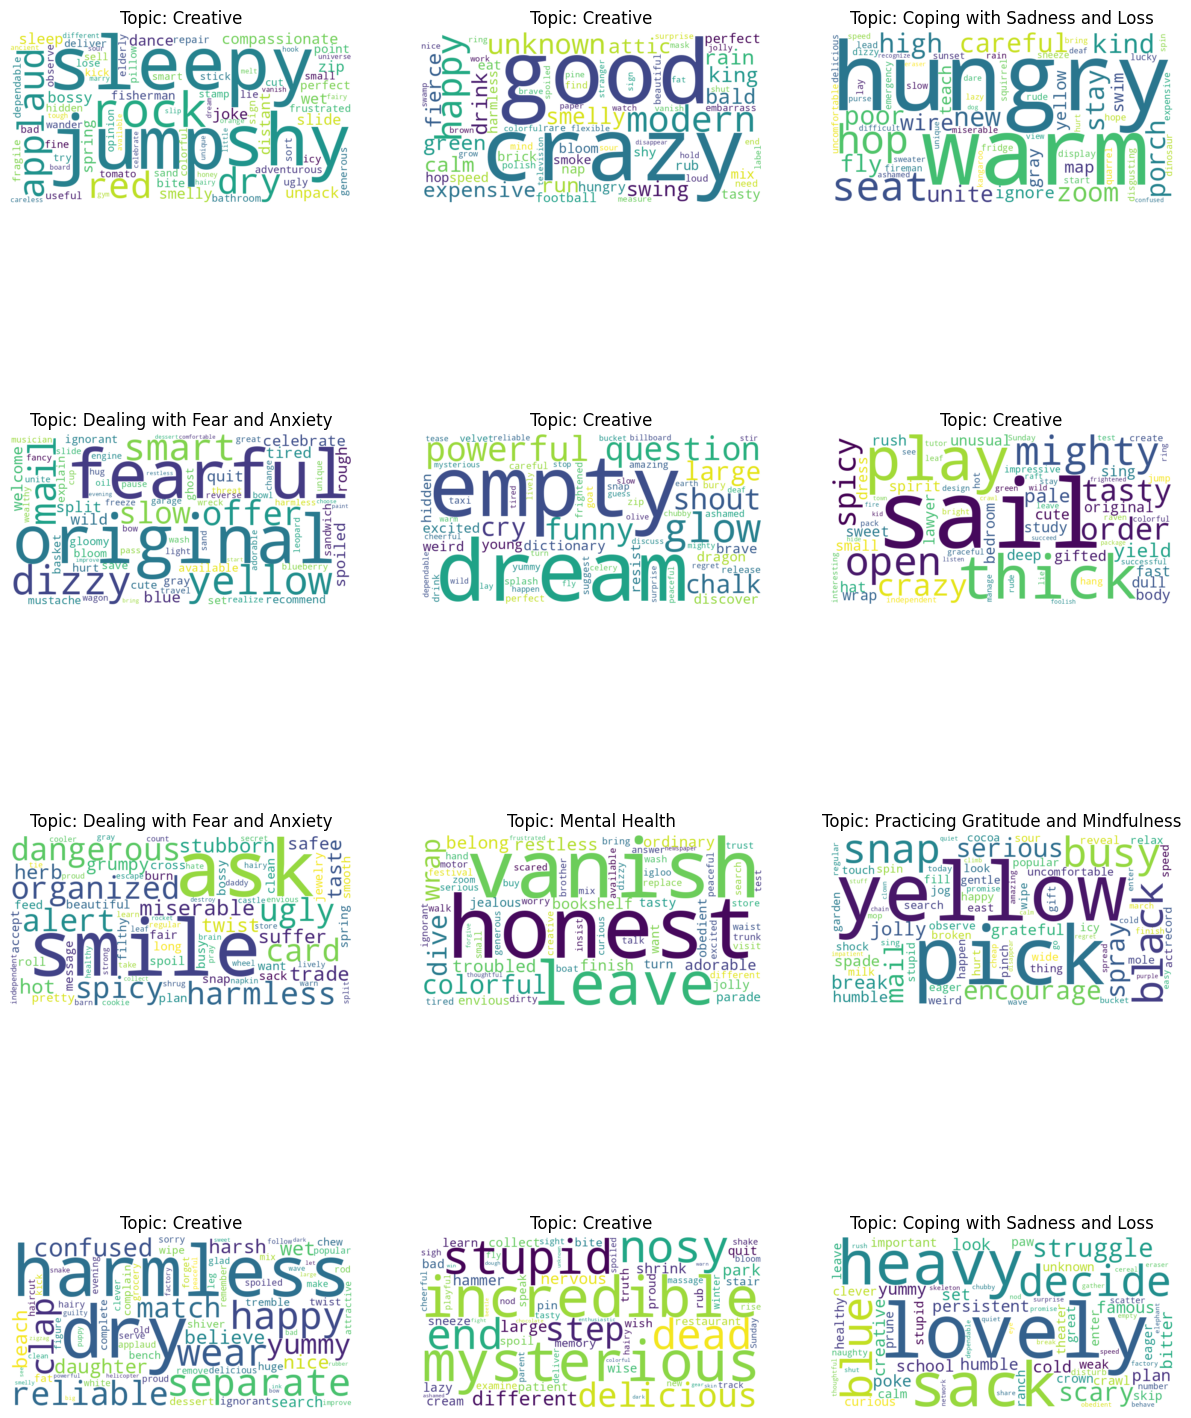

In [24]:
# Step 3: creating a word cloud for all topics within a single iteration
# add the cluster labels to the batch
sample_batch = batches[0]
batch_df = pd.DataFrame({'words': sample_batch, 'topic': topic_assignment_batches[0]})
# Determine the number of rows and columns for the grid
num_topics = len(batch_df['topic'].unique())
num_cols = 3  # Adjust as needed
num_rows = (num_topics + num_cols - 1) // num_cols

# Create the figure and axes for the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
i = 0
for topic_id in batch_df['topic'].unique():
    topic_df = batch_df[batch_df['topic'] == topic_id].copy()

    # Create a word cloud of the topics
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100)
    topic_df['words'] = topic_df['words'].apply(lambda x: ' '.join(x))
    # Concatenate all word strings in topic_df['words']
    wordcloud_text = ' '.join(topic_df['words'].values)
    # Filter counts of all words in the wordcloud_text and then select top 100 with count > 1
    wordcloud_text_counts = wordcloud.process_text(wordcloud_text)
    wordcloud_text_counts = {k: v for k, v in sorted(wordcloud_text_counts.items(), key=lambda item: item[1], reverse=True)}
    wordcloud_text_counts = dict(list(wordcloud_text_counts.items())[:100])
    wordcloud_text_counts = pd.Series(wordcloud_text_counts, index=wordcloud_text_counts.keys())
    # Filter to words with counts > 1
    wordcloud_text_counts = wordcloud_text_counts[wordcloud_text_counts > 1]
    wordcloud_text_filtered = ' '.join(wordcloud_text_counts.index)
    # Classifying the topic_df['words']
    topic = classify_topics(mental_health_topics, creativity_topics, wordcloud_text_counts.to_string())
    topic_df['topic'] = topic
    wordcloud.generate(wordcloud_text_filtered)
    # Plot the wordcloud on the corresponding subplot
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]  # Get the current subplot
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Topic: {topic}')  # Add a title/label
    i += 1


In [25]:
# Step 4: classifying all the topic_ids across all bootstrap cluster iterations
all_classified_topic_batches = []
for i in range(len(topic_assignment_batches)):
    batch_df = pd.DataFrame({'words': batches[i], 'topic': topic_assignment_batches[i]})
    for topic_id in batch_df['topic'].unique():
        topic_df = batch_df[batch_df['topic'] == topic_id].copy()
        topic_df['words'] = topic_df['words'].apply(lambda x: ' '.join(x))
        # Concatenate all word strings in topic_df['words']
        wordcloud_text = ' '.join(topic_df['words'].values)
        # Filter counts of all words in the wordcloud_text and then select top 100 with count > 1
        wordcloud_text_counts = wordcloud.process_text(wordcloud_text)
        wordcloud_text_counts = {k: v for k, v in sorted(wordcloud_text_counts.items(), key=lambda item: item[1], reverse=True)}
        wordcloud_text_counts = dict(list(wordcloud_text_counts.items())[:100])
        wordcloud_text_counts = pd.Series(wordcloud_text_counts, index=wordcloud_text_counts.keys())
        # Filter to words with counts > 1
        wordcloud_text_counts = wordcloud_text_counts[wordcloud_text_counts > 1]
        topic = classify_topics(mental_health_topics, creativity_topics, wordcloud_text_counts.to_string())
        topic_df['topic'] = topic
        all_classified_topic_batches.append(topic_df)

In [55]:
# concatenating all tables for summary
all_classified_topic_batches_df = pd.concat(all_classified_topic_batches)

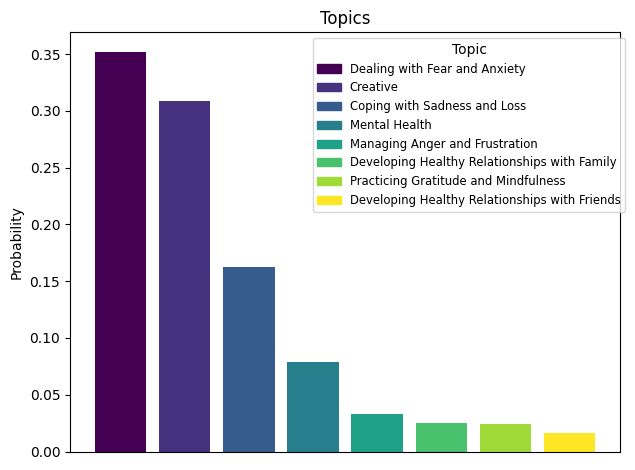

In [58]:
plot_topic_counts(all_classified_topic_batches_df)

##### Mental Health Insight
The classification of the topic id's found via clustering of the key words using a Latent Dirichlet Allocation model for latent text embedding analysis is shown above. It is surprising that a majority of the classified topic labels fall under the 'mental health' category. However, despite the language model not classifying much of the sub-categories within the 'creativity' category, it still categorized much of the clusters as belonging to the general 'creative' label.

**Note: This insight is made with only a small sample of the overall training data.**

In [64]:
# summing the probability of all labels except 'Creative'
mental_health_probability = 1 - all_classified_topic_batches_df['topic'].value_counts(normalize=True)['Creative']
creative_probability = 1 - mental_health_probability
print(f"Probability of Mental Health: {mental_health_probability}")
print(f"Probability of Creative: {creative_probability}")

Probability of Mental Health: 0.6915333333333333
Probability of Creative: 0.30846666666666667


##### Statistical Insight
A majority of the vocabulary data clusters sampled (~70%) were assigned to a variety of 'mental health' topic categories. Compared to the 'creative' topic, which only amounts to ~30% of the sampled clusters and has almost no variety in labels, it seems as if the training data provides more mental-health related key vocabulary words. This might be correlated to the influence of the 'narrative' feature category of 'badending' and 'conflict', with smaller influence due to 'moralvalue'. **It is important to note that despite this, all of the mental health narratives amount to only ~25% of the full training data and that the 'moralvalue' narrative is almost half of that of the combined 'badending' and 'conflict' narratives.**  

**Note: This insight is made with only a small sample of the overall training data.**

## Creativity
Objectively speaking, creativity is a hard goal to define as it can be objectively defined in a multitude of way, as are the aforementioned topics of literacy and mental-health. However, many people might agree that creativity is somehow unique. Therefore, it may be possible to define the goal of creativity by understanding the level of variance in the models responses to similar prompts.

### Narrative Features

##### Creativity Insight
The bar plot below shows how the narratives that were found fall under narrative types belonging to literacy (dialogue, twist, foreshadowing) or mental health (bad ending, conflict, moral value). Despite containing 6 narrative types, a majority of the narrative types belong to only a few narratives (with dialogue and twist amounting to ~70% of all narratives combined). Similarly, 'dialogue', 'twist', and 'foreshadowing' are narratives that are less creative as they do not necessarily influence the plot of the story itself and moreso influence the storytelling structure.

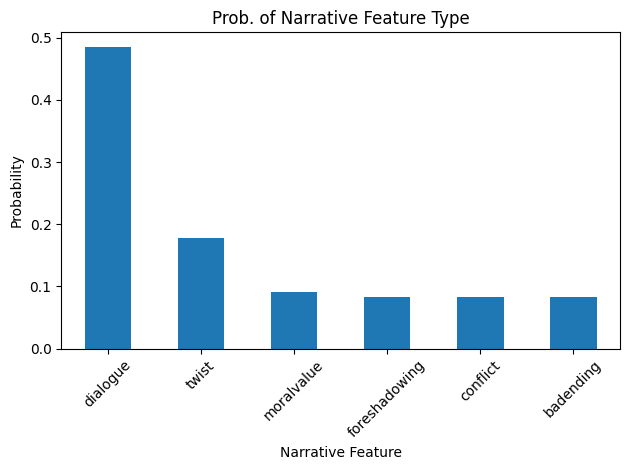

In [36]:
ax = feature_occurence_probabilities.sort_values(ascending=False).plot(
    kind='bar',
    title='Prob. of Narrative Feature Type'
)

# Correctly set labels using set methods
plt.ylabel('Probability')
plt.xlabel('Narrative Feature')
plt.xticks(rotation=45)

# Optional: Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

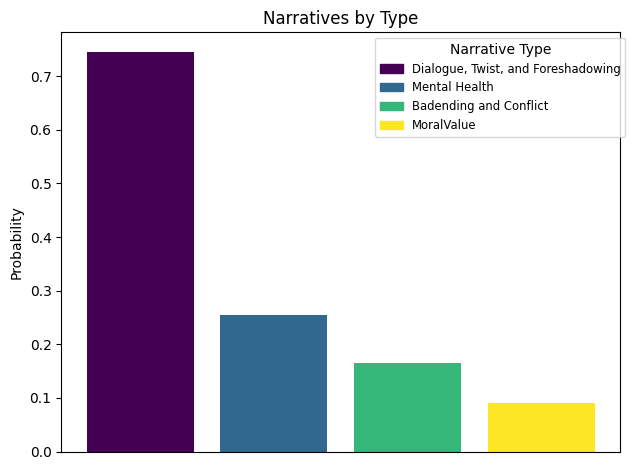

In [118]:
plot_topic_counts(narrative_probabilities_df, title='Narratives by Type', xlabel='Narrative Type', ylabel='Probability', pre_normalized=True)

##### Statistical Insight
Thus, there is a need to increase the variety of narratives, as well as to improve the distribution by removing the bias for the dialogue outlier narrative. By looking at the specific probabilities of the more creative narrative types, such as 'moralvalue', 'badending', and 'conflict' (all falling under the mental health narrative umbrella), we can gain insight into the kind's of plots featured within the stories. **The subjectively more creative mental health narrative umbrella type corresponds to ~25% of the narratives in the full training data. Thus, there is a need to increase the amount of creative narratives within the training data.**

In [108]:
print(f"Probability of Mental Health Narrative: {mental_health_narrative_probability}")
print(f"Probability of Dialogue, Twist, and Foreshadowing Narrative: {dialogue_twist_foreshadowing_narrative_probability}")
print(f"Probability of Badending and Conflict Narrative: {badending_conflict_narrative_probability}")
print(f"Probability of MoralValue Narrative: {mental_health_narrative_probability - badending_conflict_narrative_probability}")

Probability of Mental Health Narrative: 0.2553420534936641
Probability of Dialogue, Twist, and Foreshadowing Narrative: 0.7446579465063359
Probability of Badending and Conflict Narrative: 0.16503344836355346
Probability of MoralValue Narrative: 0.09030860513011066


### Key Words

##### Creativity Insight
In the barplot, we can see that the creativity and mental health topics classified using the language model are mostly highlighting the 'mental health' category and lack the subcategories that were provided for the 'creativity' category. Despite the lack of sufficient description of the kinds of 'creativity', 'creativity' as a general label for the latent text embedding clusters is still the second-most popular label.

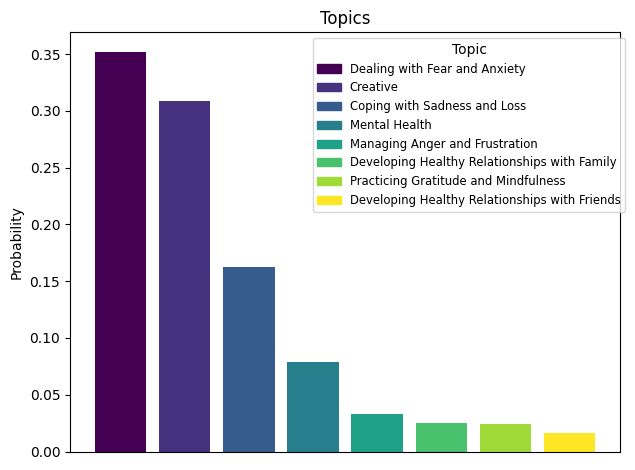

In [60]:
plot_topic_counts(all_classified_topic_batches_df)

##### Statistical Insight
The cumulative probability for the mental health topic category for the vocabulary key words far outweighs that of the singular 'creative' label, despite the 'creative' label being the second-most popular. As shown in the above probability values, 'creativity' is only ~30% of the vocabulary word clusters. Future prompt generation should potentially focus on including more prompts that highlight creative activities in the stories such as the 'painting', 'music', or 'sculpting' categories provided to the language model for classification that were ultimately not assigned during classification.

In [65]:
# summing the probability of all labels except 'Creative'
mental_health_probability = 1 - all_classified_topic_batches_df['topic'].value_counts(normalize=True)['Creative']
creative_probability = 1 - mental_health_probability
print(f"Probability of Mental Health: {mental_health_probability}")
print(f"Probability of Creative: {creative_probability}")

Probability of Mental Health: 0.6915333333333333
Probability of Creative: 0.30846666666666667


## Literacy
WonderWords' literacy goals may be defined in objective terms by classifying whether the responses are at a lower or a higher reading level. As our application is targeting a youth demographic, utilizing the categorization system used in grade level school systems will help illustrate whether the training data is biased towards a specific set of reading levels.

### Narrative Features

##### Literacy Insight
As has been previously mentioned, non-mental-health related narrative features in the training data dominate. The combined 'dialogue', 'twist', and 'foreshadowing' narrative types amount to ~75% of the full training data. This underlines the importance of literacy via storytelling elements within the TinyStories dataset over specific outcomes such as 'badending' 'conflict' or 'moralvalue'.

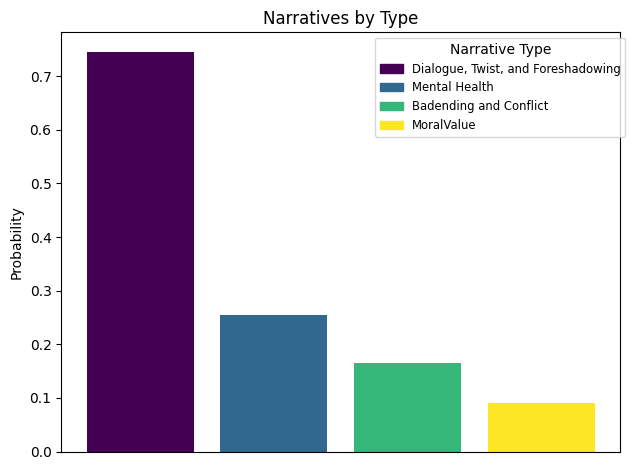

In [117]:
plot_topic_counts(narrative_probabilities_df, title='Narratives by Type', xlabel='Narrative Type', ylabel='Probability', pre_normalized=True)

##### Statistical Insight
Looking at the cumulative probability (~75%) of the 'dialogue', 'twist', and 'foreshadowing' narrative types does not accurately describe the influence of variance due to literacy-related narratives. As we can see by looking at the individual probabilities for these narratives, dialogue accounts for 48% of prompts, and the second-highest is twist with ~18% of prompts. Lastly, foreshadowing only accounts for ~8%. **The ratio is thus about 6:2:1 for dialogue, twist, and foreshadowing in terms of importance. This makes 'dialogue' the strength of the TinyStories dataset, and shows how literacy could be improved by adding more narrative elements such as 'twist' and 'foreshadowing'.**

In [112]:
print(f"Probability of Dialogue, Twist, and Foreshadowing Narrative: {dialogue_twist_foreshadowing_narrative_probability}")

Probability of Dialogue, Twist, and Foreshadowing Narrative: 0.7446579465063359


In [120]:
# individual probabilities for dialogue, twist, and foreshadowing
feature_occurence_probabilities.loc[['dialogue', 'twist','foreshadowing']]

,feature_occurrences
feature,
dialogue,0.484367
twist,0.177679
foreshadowing,0.082613


### Key Words

In [28]:
literacy_levels = [
    "Kindergarten (5-6)",
    "1st Grade (6-7)",
    "2nd Grade (7-8)",
    "3rd Grade (8-9)",
    "4th Grade (9-10)",
    "5th Grade (10-11)",
    "6th Grade (11-12)",
    "7th Grade (12-13)",
    "8th Grade (13-14)",
    "9th Grade (14-15)",
    "10th Grade (15-16)",
    "11th Grade (16-17)",
    "12th Grade (17-18)"
]

In [32]:
def classify_literacy(literacy_levels, topic_df_words_counts):
    """ this takes a preset list of literacy levels,
        and classifies the topic_ids by using the data in the topic_df_words
        note: there are 12 topic_ids and 13 corresponding literacy levels.
        """
    prompt_template = (
        f"The following is a list of education levels and corresponding ages: {literacy_levels}",
        f"Use this list of words and their probabilities to classify the most likely level for this set of words: {topic_df_words_counts}",
        "Note: Each topic in either list can be assigned only once. Only respond with the topic chosen and nothing else.",
        "Nearest literacy level: "
    )
    prompt = "\n".join(prompt_template)
    response = client.chat.completions.create(
        messages=[
            {"role": "system", "content": "You are comfortable classifying the language used in stories by simply inferring based on words and classifying a collection into literacy levels."},
            {"role": "user", "content": prompt}
        ],
        model = model,
        temperature = 0.0
    )
    return response.choices[0].message.content

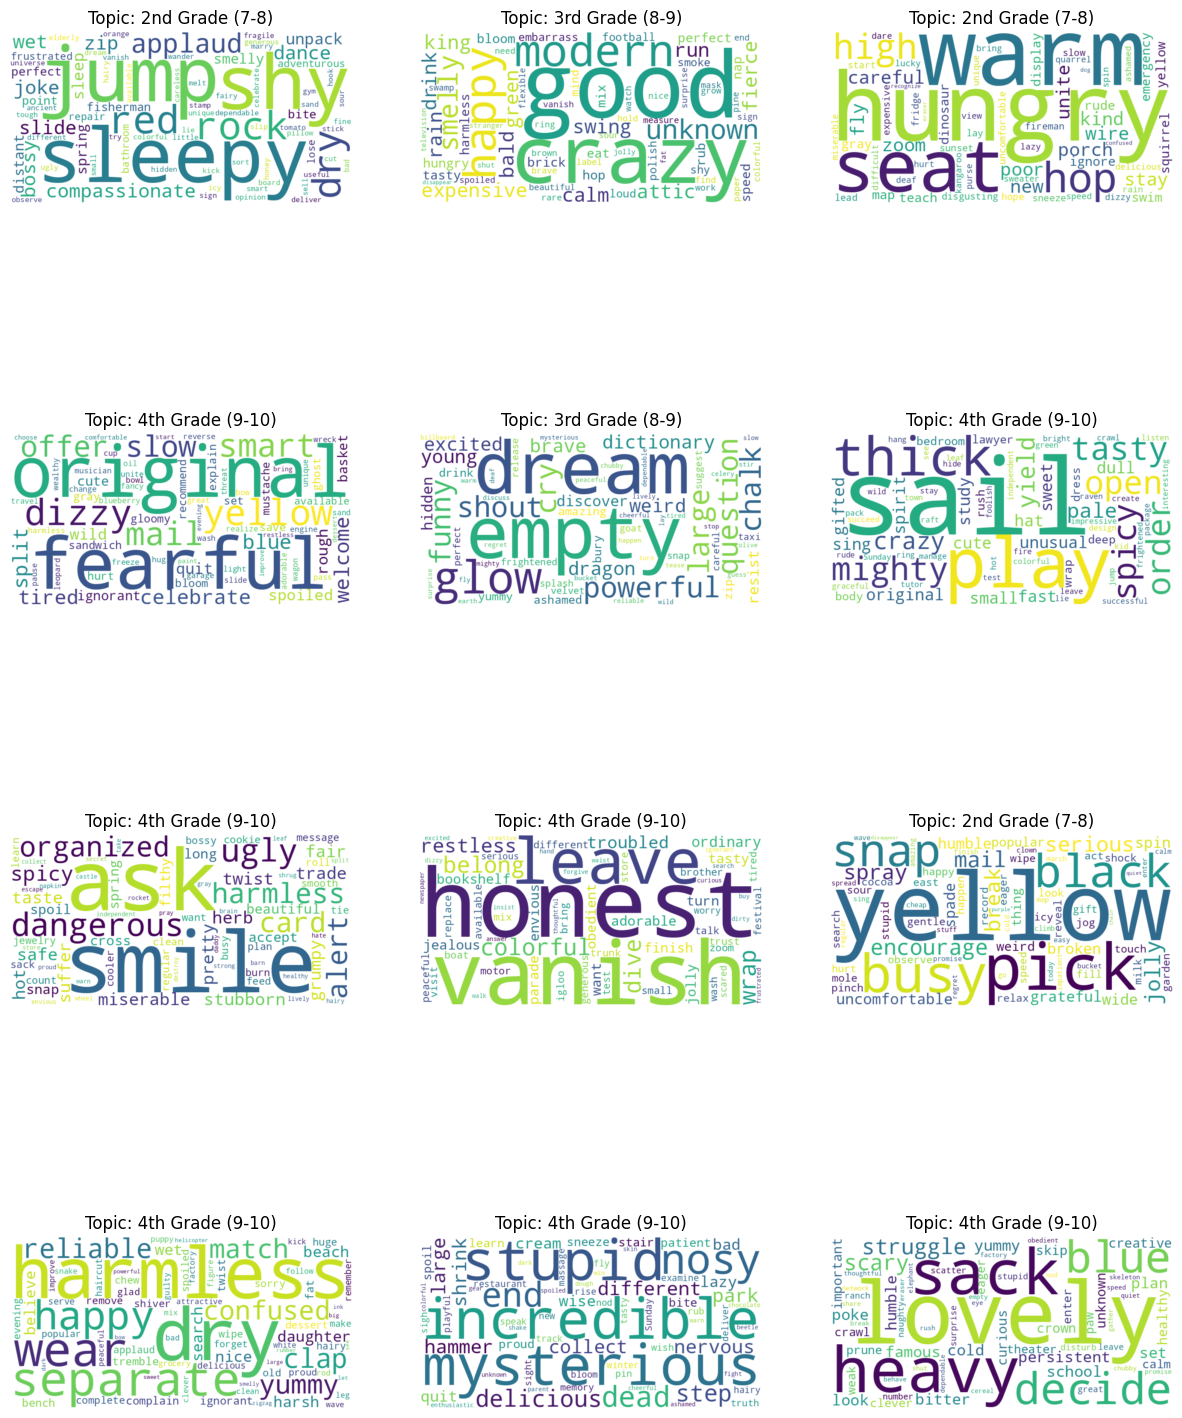

In [33]:
# Step 3: creating a word cloud for all topics within a single iteration
# add the cluster labels to the batch
sample_batch = batches[0]
batch_df = pd.DataFrame({'words': sample_batch, 'topic': topic_assignment_batches[0]})
# Determine the number of rows and columns for the grid
num_topics = len(batch_df['topic'].unique())
num_cols = 3  # Adjust as needed
num_rows = (num_topics + num_cols - 1) // num_cols

# Create the figure and axes for the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
i = 0
for topic_id in batch_df['topic'].unique():
    topic_df = batch_df[batch_df['topic'] == topic_id].copy()

    # Create a word cloud of the topics
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100)
    topic_df['words'] = topic_df['words'].apply(lambda x: ' '.join(x))
    # Concatenate all word strings in topic_df['words']
    wordcloud_text = ' '.join(topic_df['words'].values)
    # Filter counts of all words in the wordcloud_text and then select top 100 with count > 1
    wordcloud_text_counts = wordcloud.process_text(wordcloud_text)
    wordcloud_text_counts = {k: v for k, v in sorted(wordcloud_text_counts.items(), key=lambda item: item[1], reverse=True)}
    wordcloud_text_counts = dict(list(wordcloud_text_counts.items())[:100])
    wordcloud_text_counts = pd.Series(wordcloud_text_counts, index=wordcloud_text_counts.keys())
    # Filter to words with counts > 1
    wordcloud_text_counts = wordcloud_text_counts[wordcloud_text_counts > 1]
    wordcloud_text_filtered = ' '.join(wordcloud_text_counts.index)
    # Classifying the topic_df['words']
    topic = classify_literacy(literacy_levels, wordcloud_text_counts.to_string())
    topic_df['topic'] = topic
    wordcloud.generate(wordcloud_text_filtered)
    # Plot the wordcloud on the corresponding subplot
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]  # Get the current subplot
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Topic: {topic}')  # Add a title/label
    i += 1

In [34]:
# Step 4: classifying all the topic_ids across all bootstrap cluster iterations
all_classified_literacy_batches = []
for i in range(len(topic_assignment_batches)):
    batch_df = pd.DataFrame({'words': batches[i], 'topic': topic_assignment_batches[i]})
    for topic_id in batch_df['topic'].unique():
        topic_df = batch_df[batch_df['topic'] == topic_id].copy()
        topic_df['words'] = topic_df['words'].apply(lambda x: ' '.join(x))
        # Concatenate all word strings in topic_df['words']
        wordcloud_text = ' '.join(topic_df['words'].values)
        # Filter counts of all words in the wordcloud_text and then select top 100 with count > 1
        wordcloud_text_counts = wordcloud.process_text(wordcloud_text)
        wordcloud_text_counts = {k: v for k, v in sorted(wordcloud_text_counts.items(), key=lambda item: item[1], reverse=True)}
        wordcloud_text_counts = dict(list(wordcloud_text_counts.items())[:100])
        wordcloud_text_counts = pd.Series(wordcloud_text_counts, index=wordcloud_text_counts.keys())
        # Filter to words with counts > 1
        wordcloud_text_counts = wordcloud_text_counts[wordcloud_text_counts > 1]
        topic = classify_literacy(literacy_levels, wordcloud_text_counts.to_string())
        topic_df['topic'] = topic
        all_classified_literacy_batches.append(topic_df)

In [121]:
all_classified_literacy_batches_df = pd.concat(all_classified_literacy_batches)

##### Literacy Insight
The plot below shows how the language model classified the clusters of the vocabulary key words that were sampled and then clustered via the LDA/text embedding analysis method. Although the language model was provided a list of labels ranging from kindergarden to grade 12, it only classified labels belonging to the elementary grade school levels. This shows that the TinyStories dataset may have unintentionally placed an emphasis on youth by prompting GPT-4 to respond with short 3-4 sentence responses, therefore restricting the level of vocabulary to lower literacy levels. In order to raise the literacy levels, it might be useful to update the prompts in the training data to ask for longer output or for more complex word choices.

**Note: This insight is made on small batched samples of the overall dataset.**

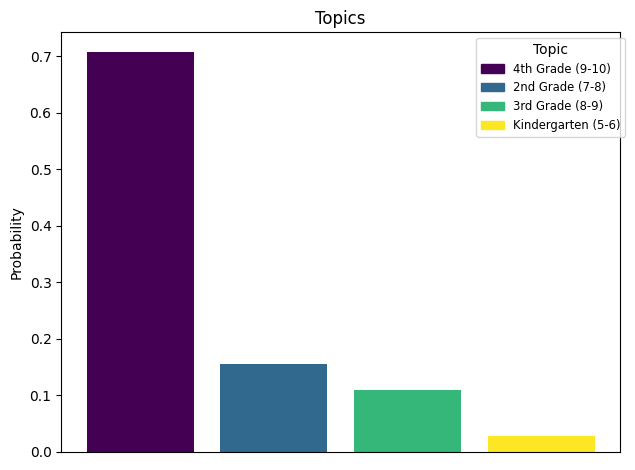

In [61]:
plot_topic_counts(all_classified_literacy_batches_df)

##### Statistical Insight
The cumulative probability of the grade levels found during classification underlines the importance of elementary level story prompts in the training data. On the other hand, the cumulative probability doesn't provide information on the specific age or grade levels that might find these story prompts interesting. For example, the 4th grade level is a heavy outlier that amounts to ~70% of the sampled clusters found. Similarly, the Kindergarten grade level is another outlier and only amounts to ~3% of the sampled clusters found. **This implies that although the classified grade levels correspond to elementary grades - there is a heavy preference for the middle year elementary ages of 8-10 years old and 3-4th grade. Furthermore, the classification left out the 5th grade level, further showing how the language model classified intermediary elementary grade level literacy.**

**Note: This insight is made on small batched samples of the overall dataset.**

In [124]:
all_classified_literacy_batches_df['topic'].value_counts(normalize=True)

,proportion
topic,
4th Grade (9-10),0.706667
2nd Grade (7-8),0.155733
3rd Grade (8-9),0.109600
Kindergarten (5-6),0.028000
